# ScoreSight - Match Winner Prediction
Author: Rishi Khandekar  
Internship: Infosys  
Goal: Predict Match Winner (Win/Draw/Loss)

## 1. Install & Imports

In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ------- -------------------------------- 2.1/11.0 MB 11.3 MB/s eta 0:00:01
   -------------- ------------------------- 3.9/11.0 MB 10.4 MB/s eta 0:00:01
   -------------------- ------------------- 5.5/11.0 MB 8.9 MB/s eta 0:00:01
   --------------------------- ------------ 7.6/11.0 MB 9.2 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/11.0 MB 9.2 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 8.8 MB/s  0:00:01
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/8.1 MB 10.8 MB/s eta 0:00:01
   ------------------- -------------------- 3.9/8.1 MB 10.5 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 9.7 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 9.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 9.4 MB/s  0:00:00
   -----------------

In [3]:
# Install optional packages if not present (imblearn, xgboost)
import sys
try:
    import imblearn
except Exception:
    !{sys.executable} -m pip install -q imbalanced-learn
try:
    import xgboost
except Exception:
    !{sys.executable} -m pip install -q xgboost

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

sns.set(style='whitegrid')

## 2. Load Dataset

In [4]:
# Adjust path if necessary
df = pd.read_csv("Match Winner.csv")
print("Shape:", df.shape)
display(df.head())

Shape: (9380, 22)


,Season,MatchDate,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,...,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
0,2000/01,2000-08-19,Charlton,Man City,4,0,H,2,0,H,...,14,4,6,6,13,12,1,2,0,0
1,2000/01,2000-08-19,Chelsea,West Ham,4,2,H,1,0,H,...,10,5,7,7,19,14,1,2,0,0
2,2000/01,2000-08-19,Coventry,Middlesbrough,1,3,A,1,1,D,...,3,9,8,4,15,21,5,3,1,0
3,2000/01,2000-08-19,Derby,Southampton,2,2,D,1,2,A,...,4,6,5,8,11,13,1,1,0,0
4,2000/01,2000-08-19,Leeds,Everton,2,0,H,2,0,H,...,8,6,6,4,21,20,1,3,0,0


## 3. Verify Required Columns

In [5]:
print('Columns:') 
print(df.columns.tolist())

# Check presence of half-time columns
for c in ['HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'HalfTimeResult']:
    print(c, 'in df ->', c in df.columns)

Columns:
['Season', 'MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeHomeGoals', 'FullTimeAwayGoals', 'FullTimeResult', 'HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'HalfTimeResult', 'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards']
HalfTimeHomeGoals in df -> True
HalfTimeAwayGoals in df -> True
HalfTimeResult in df -> True


## 4. Drop Irrelevant / Leaky Columns
Drop `Season`, `MatchDate`, `FullTimeHomeGoals`, `FullTimeAwayGoals` to avoid leakage.

In [6]:
drop_cols = ['Season','MatchDate','FullTimeHomeGoals','FullTimeAwayGoals']
cols_to_drop = [c for c in drop_cols if c in df.columns]
df = df.drop(columns=cols_to_drop)
print('Dropped:', cols_to_drop)
print('Remaining columns:', df.columns.tolist())

Dropped: ['Season', 'MatchDate', 'FullTimeHomeGoals', 'FullTimeAwayGoals']
Remaining columns: ['HomeTeam', 'AwayTeam', 'FullTimeResult', 'HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'HalfTimeResult', 'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards']


## 5. Missing Values & Basic Cleaning

In [7]:
# Show missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing>0]

Series([], dtype: int64)

In [9]:
# Simple strategy: drop rows with missing target or half-time features; fill others if small number
target_col = 'FullTimeResult'
print('Target column assumed:', target_col)

# Drop rows missing the target or half-time columns
df = df.dropna(subset=[target_col] + [c for c in ['HalfTimeHomeGoals','HalfTimeAwayGoals','HalfTimeResult'] if c in df.columns])

# If remaining missing values exist, show count and fill numeric with median as conservative choice
if df.isnull().sum().sum() > 0:
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    for c in num_cols:
        if df[c].isnull().sum() > 0:
            df[c].fillna(df[c].median(), inplace=True)
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    for c in cat_cols:
        if df[c].isnull().sum() > 0:
            df[c].fillna('Missing', inplace=True)

print('After cleaning, shape:', df.shape)

Target column assumed: FullTimeResult
After cleaning, shape: (9380, 18)


## 6. Show Cleaned Dataset

In [10]:
display(df.head())
df.info()

,HomeTeam,AwayTeam,FullTimeResult,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
0,Charlton,Man City,H,2,0,H,17,8,14,4,6,6,13,12,1,2,0,0
1,Chelsea,West Ham,H,1,0,H,17,12,10,5,7,7,19,14,1,2,0,0
2,Coventry,Middlesbrough,A,1,1,D,6,16,3,9,8,4,15,21,5,3,1,0
3,Derby,Southampton,D,1,2,A,6,13,4,6,5,8,11,13,1,1,0,0
4,Leeds,Everton,H,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9380 entries, 0 to 9379
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   HomeTeam           9380 non-null   object
 1   AwayTeam           9380 non-null   object
 2   FullTimeResult     9380 non-null   object
 3   HalfTimeHomeGoals  9380 non-null   int64 
 4   HalfTimeAwayGoals  9380 non-null   int64 
 5   HalfTimeResult     9380 non-null   object
 6   HomeShots          9380 non-null   int64 
 7   AwayShots          9380 non-null   int64 
 8   HomeShotsOnTarget  9380 non-null   int64 
 9   AwayShotsOnTarget  9380 non-null   int64 
 10  HomeCorners        9380 non-null   int64 
 11  AwayCorners        9380 non-null   int64 
 12  HomeFouls          9380 non-null   int64 
 13  AwayFouls          9380 non-null   int64 
 14  HomeYellowCards    9380 non-null   int64 
 15  AwayYellowCards    9380 non-null   int64 
 16  HomeRedCards       9380 non-null   int64 


## 7. Outlier Detection (IQR Method) — numeric features

In [11]:
def outlier_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return lower, upper

num_cols = df.select_dtypes(include=np.number).columns.tolist()
print('Numeric columns:', num_cols)

# Show outlier counts for numeric columns
for c in num_cols:
    lb, ub = outlier_iqr(df[c])
    cnt = ((df[c] < lb) | (df[c] > ub)).sum()
    print(f'{c}: {cnt} outliers')

Numeric columns: ['HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards']
HalfTimeHomeGoals: 316 outliers
HalfTimeAwayGoals: 168 outliers
HomeShots: 129 outliers
AwayShots: 81 outliers
HomeShotsOnTarget: 148 outliers
AwayShotsOnTarget: 325 outliers
HomeCorners: 99 outliers
AwayCorners: 338 outliers
HomeFouls: 93 outliers
AwayFouls: 131 outliers
HomeYellowCards: 578 outliers
AwayYellowCards: 17 outliers
HomeRedCards: 561 outliers
AwayRedCards: 771 outliers


## 8. Exploratory Data Analysis (EDA)

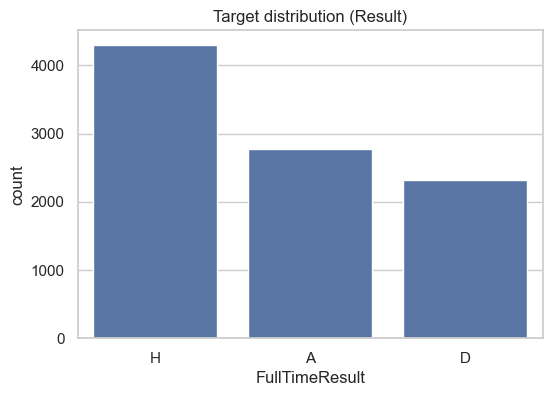

In [12]:
# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df[target_col])
plt.title('Target distribution (Result)')
plt.show()

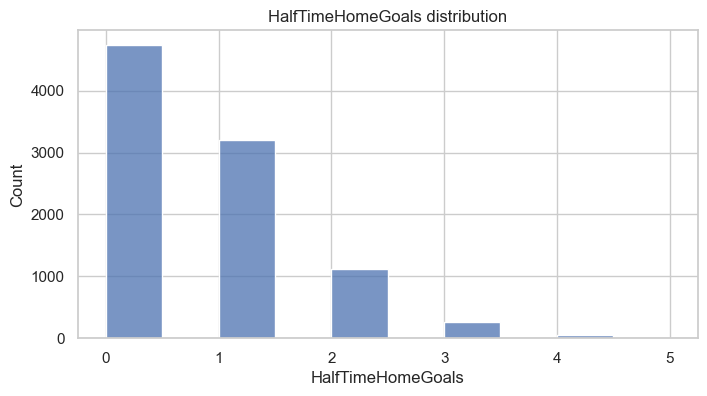

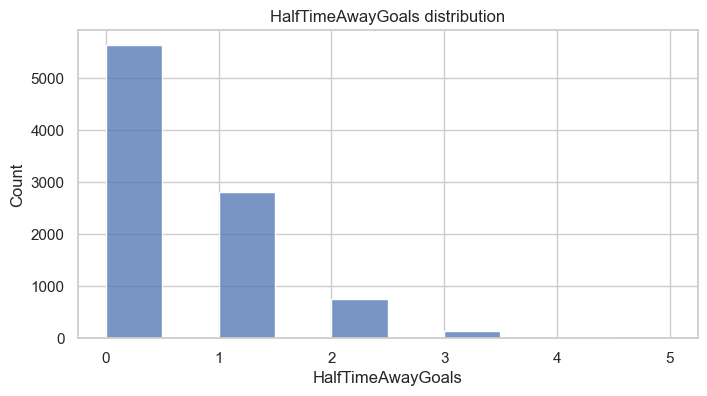

In [13]:
# Half-time goals distributions
if 'HalfTimeHomeGoals' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['HalfTimeHomeGoals'], bins=10, kde=False)
    plt.title('HalfTimeHomeGoals distribution')
    plt.show()
if 'HalfTimeAwayGoals' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['HalfTimeAwayGoals'], bins=10, kde=False)
    plt.title('HalfTimeAwayGoals distribution')
    plt.show()

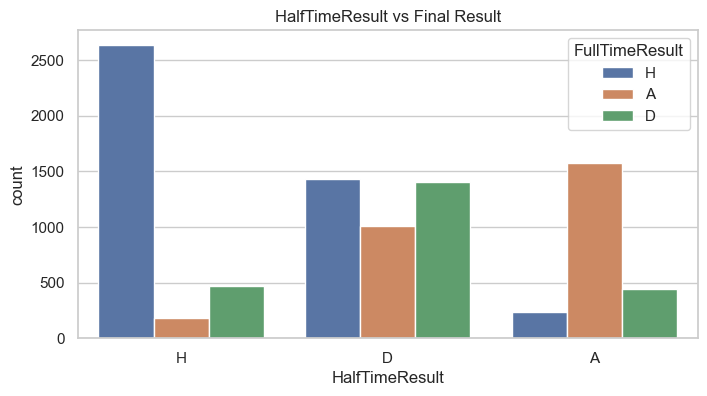

In [14]:
# Relationship between HalfTimeResult and final Result
if 'HalfTimeResult' in df.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(x='HalfTimeResult', hue=target_col, data=df)
    plt.title('HalfTimeResult vs Final Result')
    plt.show()

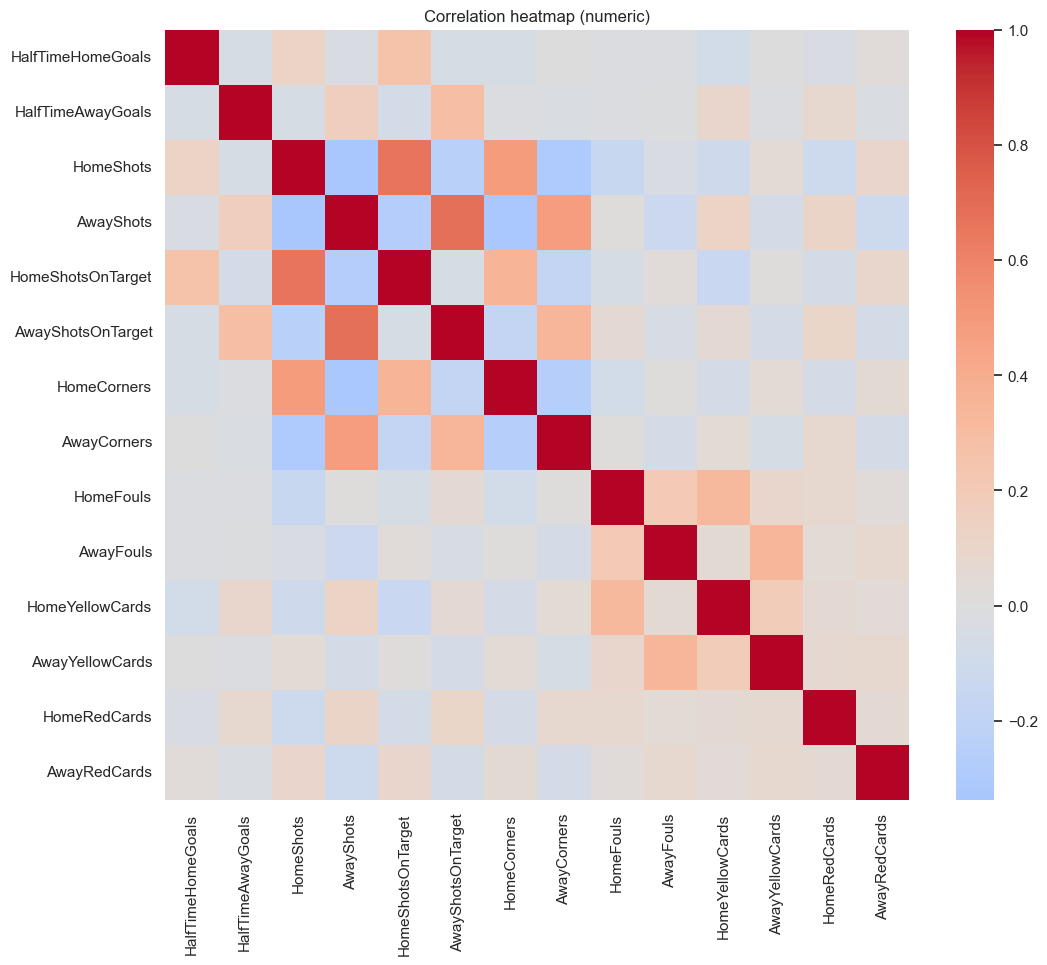

In [15]:
# Correlation heatmap for numeric features (including half-time goals)
plt.figure(figsize=(12,10))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Correlation heatmap (numeric)')
plt.show()

## 9. Feature Engineering
Create `HalfTimeGoalDiff` and `HalfTimeState` feature (HomeLead / AwayLead / Level)

In [16]:
# Half-time goal difference
if 'HalfTimeHomeGoals' in df.columns and 'HalfTimeAwayGoals' in df.columns:
    df['HalfTimeGoalDiff'] = df['HalfTimeHomeGoals'] - df['HalfTimeAwayGoals']

# HalfTimeState categorical: 'HomeLead', 'AwayLead', 'Level'
def ht_state(row):
    if row.get('HalfTimeHomeGoals', 0) > row.get('HalfTimeAwayGoals', 0):
        return 'HomeLead'
    elif row.get('HalfTimeHomeGoals', 0) < row.get('HalfTimeAwayGoals', 0):
        return 'AwayLead'
    else:
        return 'Level'

if 'HalfTimeHomeGoals' in df.columns and 'HalfTimeAwayGoals' in df.columns:
    df['HalfTimeState'] = df.apply(ht_state, axis=1)

display(df[['HalfTimeHomeGoals','HalfTimeAwayGoals','HalfTimeGoalDiff','HalfTimeState']].head())

,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeGoalDiff,HalfTimeState
0,2,0,2,HomeLead
1,1,0,1,HomeLead
2,1,1,0,Level
3,1,2,-1,AwayLead
4,2,0,2,HomeLead


## 10. Prepare Features & Target
Drop leaky columns and prepare X, y.

In [17]:
# Ensure no full-time goals remain
for c in ['FullTimeHomeGoals','FullTimeAwayGoals']:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

# Define target and features
target = target_col
# Drop target and any obvious identifiers
drop_features = [target]
# Keep all remaining columns except textual identifiers like 'MatchID' if present
for col in ['MatchID','Match_Id','ID']:
    if col in df.columns:
        drop_features.append(col)

X = df.drop(columns=drop_features)
y = df[target].copy()

print('Final feature columns count:', X.shape[1])
display(X.head())

Final feature columns count: 19


,HomeTeam,AwayTeam,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards,HalfTimeGoalDiff,HalfTimeState
0,Charlton,Man City,2,0,H,17,8,14,4,6,6,13,12,1,2,0,0,2,HomeLead
1,Chelsea,West Ham,1,0,H,17,12,10,5,7,7,19,14,1,2,0,0,1,HomeLead
2,Coventry,Middlesbrough,1,1,D,6,16,3,9,8,4,15,21,5,3,1,0,0,Level
3,Derby,Southampton,1,2,A,6,13,4,6,5,8,11,13,1,1,0,0,-1,AwayLead
4,Leeds,Everton,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0,2,HomeLead


## 11. Encoding Categorical Features
Label encode target; one-hot encode categorical features (including HalfTimeResult, HalfTimeState).

In [18]:
# Label encode target
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('Target classes:', le.classes_)

# One-hot encode categorical features
cat_cols = X.select_dtypes(include='object').columns.tolist()
print('Categorical columns to encode:', cat_cols)
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
print('Encoded feature shape:', X_encoded.shape)

Target classes: ['A' 'D' 'H']
Categorical columns to encode: ['HomeTeam', 'AwayTeam', 'HalfTimeResult', 'HalfTimeState']
Encoded feature shape: (9380, 109)


## 12. Train-Test Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (7504, 109) Test shape: (1876, 109)


## 13. Scaling (for models that benefit)

In [20]:
scaler = StandardScaler()
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

## 14. Helper: Evaluation Function

In [21]:
def evaluate(model, X_tr, y_tr, X_te, y_te, name='Model'):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    print(f'\n{name} -> Accuracy: {acc:.4f}')
    print('Confusion Matrix:\n', confusion_matrix(y_te, y_pred))
    print('Classification Report:\n', classification_report(y_te, y_pred, target_names=le.classes_))
    return acc

## 15. Week 3: Baseline Models (using encoded features)
Train baseline models and evaluate.

In [22]:
# Logistic Regression (use scaled features)
lr = LogisticRegression(max_iter=1000, random_state=42)
acc_lr = evaluate(lr, X_train_scaled, y_train, X_test_scaled, y_test, 'Logistic Regression (Baseline)')

# Decision Tree (non-scaled features)
dt = DecisionTreeClassifier(random_state=42)
acc_dt = evaluate(dt, X_train, y_train, X_test, y_test, 'Decision Tree (Baseline)')

# Random Forest (non-scaled)
rf = RandomForestClassifier(random_state=42)
acc_rf = evaluate(rf, X_train, y_train, X_test, y_test, 'Random Forest (Baseline)')

# XGBoost (use scaled or non-scaled depending on preference)
try:
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    acc_xgb = evaluate(xgb, X_train, y_train, X_test, y_test, 'XGBoost (Baseline)')
except Exception as e:
    print('XGBoost import/train failed:', e)
    acc_xgb = None


Logistic Regression (Baseline) -> Accuracy: 0.6279
Confusion Matrix:
 [[393  84  77]
 [156 101 205]
 [ 74 102 684]]
Classification Report:
               precision    recall  f1-score   support

           A       0.63      0.71      0.67       554
           D       0.35      0.22      0.27       462
           H       0.71      0.80      0.75       860

    accuracy                           0.63      1876
   macro avg       0.56      0.57      0.56      1876
weighted avg       0.60      0.63      0.61      1876


Decision Tree (Baseline) -> Accuracy: 0.5501
Confusion Matrix:
 [[312 134 108]
 [154 132 176]
 [ 94 178 588]]
Classification Report:
               precision    recall  f1-score   support

           A       0.56      0.56      0.56       554
           D       0.30      0.29      0.29       462
           H       0.67      0.68      0.68       860

    accuracy                           0.55      1876
   macro avg       0.51      0.51      0.51      1876
weighted avg     

C:\Users\rishi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:54:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost (Baseline) -> Accuracy: 0.6333
Confusion Matrix:
 [[384  85  85]
 [144 122 196]
 [ 69 109 682]]
Classification Report:
               precision    recall  f1-score   support

           A       0.64      0.69      0.67       554
           D       0.39      0.26      0.31       462
           H       0.71      0.79      0.75       860

    accuracy                           0.63      1876
   macro avg       0.58      0.58      0.58      1876
weighted avg       0.61      0.63      0.62      1876



## 16. Baseline Comparison Table

In [23]:
baseline_results = {k:v for k,v in [('Logistic Regression (Baseline)', acc_lr),
                                            ('Decision Tree (Baseline)', acc_dt),
                                            ('Random Forest (Baseline)', acc_rf),
                                            ('XGBoost (Baseline)', acc_xgb)] if v is not None}
pd.DataFrame.from_dict(baseline_results, orient='index', columns=['Accuracy']).sort_values('Accuracy', ascending=False)

,Accuracy
XGBoost (Baseline),0.633262
Random Forest (Baseline),0.630064
Logistic Regression (Baseline),0.627932
Decision Tree (Baseline),0.550107


## 17. Week 4: Hyperparameter Tuning (RandomizedSearchCV — moderate search)

In [24]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Logistic Regression tuning (small grid)
param_dist_lr = [{'penalty':['l2'],'C': [0.01,0.1,1,10],'solver':['liblinear']},
                 {'penalty':['l1'],'C':[0.01,0.1,1,10],'solver':['saga']}]
rs_lr = RandomizedSearchCV(LogisticRegression(max_iter=2000, random_state=42), param_distributions=param_dist_lr, n_iter=6, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
rs_lr.fit(X_train_scaled, y_train)
best_lr = rs_lr.best_estimator_
acc_lr_tuned = evaluate(best_lr, X_train_scaled, y_train, X_test_scaled, y_test, 'Logistic Regression (Tuned)')

# Decision Tree tuning
param_dist_dt = {'criterion':['gini','entropy'],'max_depth':[3,5,10,None],'min_samples_split':[2,5,10],'min_samples_leaf':[1,2,4]}
rs_dt = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_distributions=param_dist_dt, n_iter=8, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
rs_dt.fit(X_train, y_train)
best_dt = rs_dt.best_estimator_
acc_dt_tuned = evaluate(best_dt, X_train, y_train, X_test, y_test, 'Decision Tree (Tuned)')

# Random Forest tuning
param_dist_rf = {'n_estimators':[100,200,400],'max_depth':[None,10,20],'min_samples_split':[2,5],'min_samples_leaf':[1,2],'max_features':['sqrt','log2',None]}
rs_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist_rf, n_iter=8, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
rs_rf.fit(X_train, y_train)
best_rf = rs_rf.best_estimator_
acc_rf_tuned = evaluate(best_rf, X_train, y_train, X_test, y_test, 'Random Forest (Tuned)')

# XGBoost tuning (if available)
try:
    param_dist_xgb = {'n_estimators':[100,200,400],'max_depth':[3,5,7],'learning_rate':[0.01,0.05,0.1]}
    rs_xgb = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), param_distributions=param_dist_xgb, n_iter=8, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
    rs_xgb.fit(X_train, y_train)
    best_xgb = rs_xgb.best_estimator_
    acc_xgb_tuned = evaluate(best_xgb, X_train, y_train, X_test, y_test, 'XGBoost (Tuned)')
except Exception as e:
    print('XGBoost tuning failed or not available:', e)
    best_xgb, acc_xgb_tuned = None, None


Logistic Regression (Tuned) -> Accuracy: 0.6359
Confusion Matrix:
 [[390  82  82]
 [152  99 211]
 [ 71  85 704]]
Classification Report:
               precision    recall  f1-score   support

           A       0.64      0.70      0.67       554
           D       0.37      0.21      0.27       462
           H       0.71      0.82      0.76       860

    accuracy                           0.64      1876
   macro avg       0.57      0.58      0.57      1876
weighted avg       0.60      0.64      0.61      1876


Decision Tree (Tuned) -> Accuracy: 0.6311
Confusion Matrix:
 [[380  92  82]
 [138 128 196]
 [ 75 109 676]]
Classification Report:
               precision    recall  f1-score   support

           A       0.64      0.69      0.66       554
           D       0.39      0.28      0.32       462
           H       0.71      0.79      0.75       860

    accuracy                           0.63      1876
   macro avg       0.58      0.58      0.58      1876
weighted avg       0.61

C:\Users\rishi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rishi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost (Tuned) -> Accuracy: 0.6349
Confusion Matrix:
 [[405  58  91]
 [165  86 211]
 [ 87  73 700]]
Classification Report:
               precision    recall  f1-score   support

           A       0.62      0.73      0.67       554
           D       0.40      0.19      0.25       462
           H       0.70      0.81      0.75       860

    accuracy                           0.63      1876
   macro avg       0.57      0.58      0.56      1876
weighted avg       0.60      0.63      0.60      1876



## 18. Tuning Comparison Table

In [25]:
tuned_results = {k:v for k,v in [('Logistic Regression (Tuned)', acc_lr_tuned),
                                            ('Decision Tree (Tuned)', acc_dt_tuned),
                                            ('Random Forest (Tuned)', acc_rf_tuned),
                                            ('XGBoost (Tuned)', acc_xgb_tuned)] if v is not None}
pd.DataFrame.from_dict(tuned_results, orient='index', columns=['Accuracy']).sort_values('Accuracy', ascending=False)

,Accuracy
Logistic Regression (Tuned),0.635928
Random Forest (Tuned),0.635394
XGBoost (Tuned),0.634861
Decision Tree (Tuned),0.631130


## 19. Class Imbalance Handling: SMOTE, Class Weights, and Combined

In [26]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print('After SMOTE class counts:', np.bincount(y_train_sm))

After SMOTE class counts: [3439 3439 3439]


### Retrain tuned models on SMOTE data

In [27]:
# Logistic Regression on SMOTE (use scaled features)
# Need to scale SMOTE data's numeric cols
X_train_sm_scaled = X_train_sm.copy()
X_train_sm_scaled[num_cols] = scaler.fit_transform(X_train_sm[num_cols])
acc_lr_sm = evaluate(best_lr, X_train_sm_scaled, y_train_sm, X_test_scaled, y_test, 'Logistic Regression (Tuned on SMOTE)')

# Decision Tree on SMOTE (no scaling required)
acc_dt_sm = evaluate(best_dt, X_train_sm, y_train_sm, X_test, y_test, 'Decision Tree (Tuned on SMOTE)')

# Random Forest on SMOTE
acc_rf_sm = evaluate(best_rf, X_train_sm, y_train_sm, X_test, y_test, 'Random Forest (Tuned on SMOTE)')

# XGBoost on SMOTE if available (scale features if necessary)
try:
    X_train_sm_for_xgb = X_train_sm.copy()
    X_train_sm_for_xgb[num_cols] = scaler.transform(X_train_sm[num_cols])
    acc_xgb_sm = evaluate(best_xgb, X_train_sm_for_xgb, y_train_sm, X_test_scaled, y_test, 'XGBoost (Tuned on SMOTE)')
except Exception as e:
    print('XGBoost SMOTE retrain failed or not available:', e)
    acc_xgb_sm = None


Logistic Regression (Tuned on SMOTE) -> Accuracy: 0.6194
Confusion Matrix:
 [[395 111  48]
 [157 163 142]
 [ 76 180 604]]
Classification Report:
               precision    recall  f1-score   support

           A       0.63      0.71      0.67       554
           D       0.36      0.35      0.36       462
           H       0.76      0.70      0.73       860

    accuracy                           0.62      1876
   macro avg       0.58      0.59      0.58      1876
weighted avg       0.62      0.62      0.62      1876


Decision Tree (Tuned on SMOTE) -> Accuracy: 0.6002
Confusion Matrix:
 [[384 130  40]
 [146 226  90]
 [ 71 273 516]]
Classification Report:
               precision    recall  f1-score   support

           A       0.64      0.69      0.66       554
           D       0.36      0.49      0.41       462
           H       0.80      0.60      0.69       860

    accuracy                           0.60      1876
   macro avg       0.60      0.59      0.59      1876
weigh

C:\Users\rishi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:57:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Class-Weight Experiments

In [28]:
# Compute class weights dict
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, cw))
print('Class weights:', class_weight_dict)

# Train classifiers with class_weight where supported
lr_cw = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
acc_lr_cw = evaluate(lr_cw, X_train_scaled, y_train, X_test_scaled, y_test, 'Logistic Regression (ClassWeight)')

dt_cw = DecisionTreeClassifier(class_weight='balanced', random_state=42)
acc_dt_cw = evaluate(dt_cw, X_train, y_train, X_test, y_test, 'Decision Tree (ClassWeight)')

rf_cw = RandomForestClassifier(class_weight='balanced', random_state=42)
acc_rf_cw = evaluate(rf_cw, X_train, y_train, X_test, y_test, 'Random Forest (ClassWeight)')

Class weights: {np.int64(0): np.float64(1.1297801866907557), np.int64(1): np.float64(1.3513416171438861), np.int64(2): np.float64(0.7273432199282738)}

Logistic Regression (ClassWeight) -> Accuracy: 0.6103
Confusion Matrix:
 [[368 145  41]
 [143 200 119]
 [ 61 222 577]]
Classification Report:
               precision    recall  f1-score   support

           A       0.64      0.66      0.65       554
           D       0.35      0.43      0.39       462
           H       0.78      0.67      0.72       860

    accuracy                           0.61      1876
   macro avg       0.59      0.59      0.59      1876
weighted avg       0.64      0.61      0.62      1876


Decision Tree (ClassWeight) -> Accuracy: 0.5533
Confusion Matrix:
 [[332 144  78]
 [140 150 172]
 [102 202 556]]
Classification Report:
               precision    recall  f1-score   support

           A       0.58      0.60      0.59       554
           D       0.30      0.32      0.31       462
           H       0.69

### SMOTE + Class-Weight Combined (retrain tuned models)

In [29]:
# Use best estimators retrained on SMOTE but with class weights where applicable
# For demonstration, fit a fresh estimator with class_weight on SMOTE data
lr_sm_cw = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
# scale features
X_train_sm_scaled = X_train_sm.copy()
X_train_sm_scaled[num_cols] = scaler.fit_transform(X_train_sm[num_cols])
acc_lr_sm_cw = evaluate(lr_sm_cw, X_train_sm_scaled, y_train_sm, X_test_scaled, y_test, 'Logistic Regression (SMOTE + ClassWeight)')

dt_sm_cw = DecisionTreeClassifier(class_weight='balanced', random_state=42)
acc_dt_sm_cw = evaluate(dt_sm_cw, X_train_sm, y_train_sm, X_test, y_test, 'Decision Tree (SMOTE + ClassWeight)')

rf_sm_cw = RandomForestClassifier(class_weight='balanced', random_state=42)
acc_rf_sm_cw = evaluate(rf_sm_cw, X_train_sm, y_train_sm, X_test, y_test, 'Random Forest (SMOTE + ClassWeight)')


Logistic Regression (SMOTE + ClassWeight) -> Accuracy: 0.6199
Confusion Matrix:
 [[403  88  63]
 [169 121 172]
 [ 83 138 639]]
Classification Report:
               precision    recall  f1-score   support

           A       0.62      0.73      0.67       554
           D       0.35      0.26      0.30       462
           H       0.73      0.74      0.74       860

    accuracy                           0.62      1876
   macro avg       0.57      0.58      0.57      1876
weighted avg       0.60      0.62      0.61      1876


Decision Tree (SMOTE + ClassWeight) -> Accuracy: 0.5341
Confusion Matrix:
 [[318 142  94]
 [158 155 149]
 [116 215 529]]
Classification Report:
               precision    recall  f1-score   support

           A       0.54      0.57      0.55       554
           D       0.30      0.34      0.32       462
           H       0.69      0.62      0.65       860

    accuracy                           0.53      1876
   macro avg       0.51      0.51      0.51      

## 22. Final Comparison of Experiments

In [30]:
results_all = {
    'LogReg (Baseline)': acc_lr,
    'DT (Baseline)': acc_dt,
    'RF (Baseline)': acc_rf,
    'XGB (Baseline)': acc_xgb if acc_xgb is not None else np.nan,
    'LogReg (Tuned)': acc_lr_tuned,
    'DT (Tuned)': acc_dt_tuned,
    'RF (Tuned)': acc_rf_tuned,
    'XGB (Tuned)': acc_xgb_tuned if 'acc_xgb_tuned' in globals() else np.nan,
    'LogReg (SMOTE Tuned)': acc_lr_sm if 'acc_lr_sm' in globals() else np.nan,
    'DT (SMOTE Tuned)': acc_dt_sm if 'acc_dt_sm' in globals() else np.nan,
    'RF (SMOTE Tuned)': acc_rf_sm if 'acc_rf_sm' in globals() else np.nan,
    'XGB (SMOTE Tuned)': acc_xgb_sm if 'acc_xgb_sm' in globals() else np.nan,
    'LogReg (ClassWeight)': acc_lr_cw,
    'DT (ClassWeight)': acc_dt_cw,
    'RF (ClassWeight)': acc_rf_cw,
    'LogReg (SMOTE+CW)': acc_lr_sm_cw if 'acc_lr_sm_cw' in globals() else np.nan,
    'DT (SMOTE+CW)': acc_dt_sm_cw if 'acc_dt_sm_cw' in globals() else np.nan,
    'RF (SMOTE+CW)': acc_rf_sm_cw if 'acc_rf_sm_cw' in globals() else np.nan
}

res_df = pd.DataFrame.from_dict(results_all, orient='index', columns=['Accuracy']).dropna().sort_values('Accuracy', ascending=False)
display(res_df)

,Accuracy
LogReg (Tuned),0.635928
RF (Tuned),0.635394
XGB (Tuned),0.634861
XGB (Baseline),0.633262
DT (Tuned),0.631130
RF (ClassWeight),0.630597
RF (Baseline),0.630064
LogReg (Baseline),0.627932
RF (SMOTE+CW),0.625800
RF (SMOTE Tuned),0.623667


## 23. Documentation & Conclusion
- Summarize the impact of half-time features on accuracy.
- Note which method gave the best improvement and by how much.
- Recommendations: feature engineering (form, head-to-head), more data, ensemble/stacking if needed.